## What to do?

Just run the cells that you need.
There's different sections for the different model architectures

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from time import time
from models import ResNet
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

2022-04-10 10:07:11.890645: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

import training and validation data
not included in repo, set your own folder location

In [3]:
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')
X_val = np.load('data/X_val.npy')
Y_val = np.load('data/Y_val.npy')

In [4]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bird', 'bed', 'house', 'seven', 'six', 'nine', 'dog', 'two', 'eight', 'four', 'tree', 'zero', 'marvin', 'happy', 'sheila', 'wow', 'three', 'one', 'cat', 'five']


In [5]:
# for label in all_classes:
#    print(data[label].shape, ':)')

The training data is very unbalanced with a much larger 'unknown' class.
keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [6]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [7]:
class_weights

{11: 1.0,
 0: 17.399810964083176,
 3: 17.574224343675418,
 10: 101.98891966759003,
 1: 17.490736342042755,
 5: 17.441023211747986,
 9: 17.432765151515152,
 2: 17.4080378250591,
 6: 17.449289099526066,
 8: 17.253045923149017,
 4: 17.482431149097817,
 7: 17.52403617325083}

some constants we need for all models

In [8]:
input_size = X_train.shape[1:]
batch_size = 196

## First the ResNet
declare filters for each block of blocks and set output size.

In [9]:
filters_list = [8,16,32]
output_size = 12

In [10]:
#adjust these strings for organizeing the saved files
date = '20220409'
arch = 'resnet8_16_32'

Build the model

In [12]:
sr = ResNet(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])

2022-04-09 19:14:50.306647: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-09 19:14:50.385169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 19:14:50.392005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-09 19:14:50.392485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-09 19:14:50.458018: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-09 19:14:50.458222: I tensorflow/stream_executor/platf

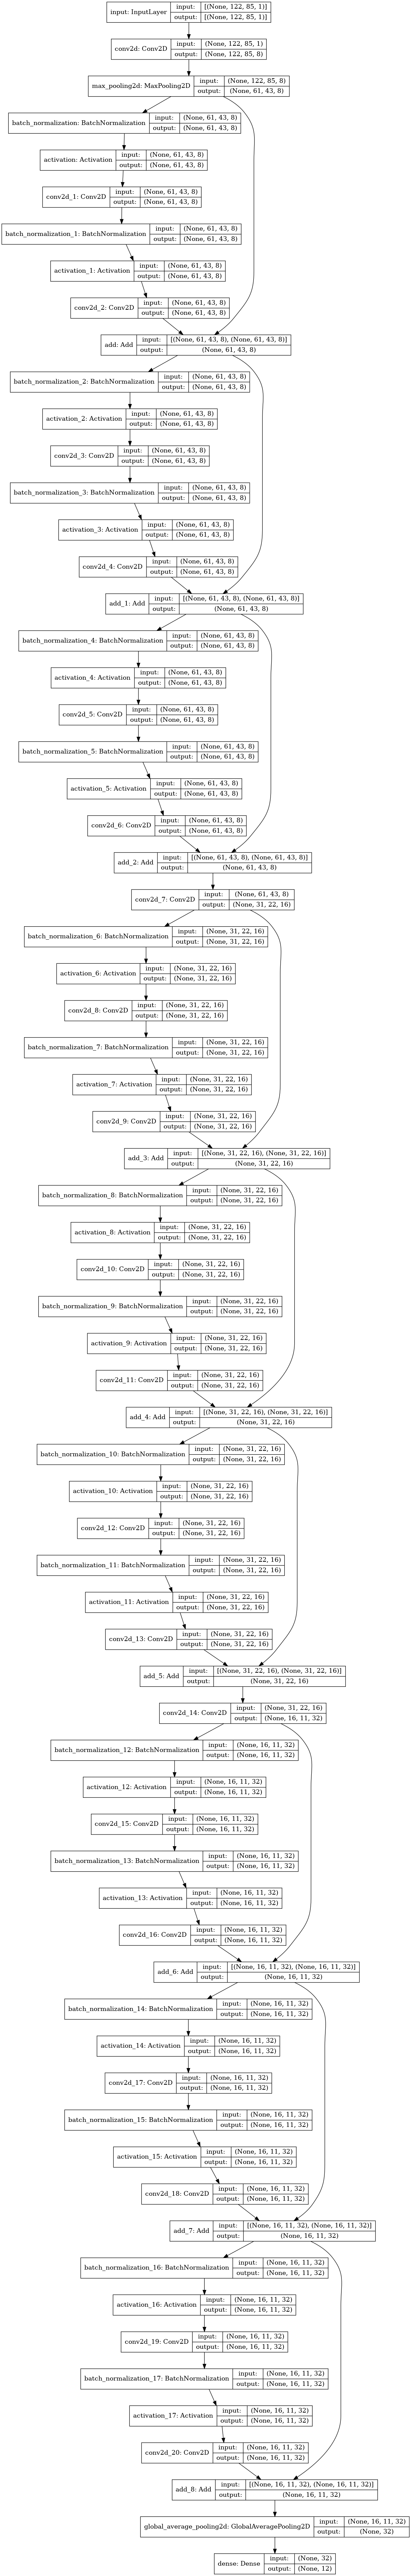

In [13]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [14]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

2022-04-09 19:16:30.189676: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-09 19:16:30.189706: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-09 19:16:30.205987: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-09 19:16:30.234827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2022-04-09 19:16:30.439472: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-09 19:16:30.443750: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


train the model
the history object stores training data for later access, like plotting training curves

In [75]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 5, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer, tensorboard]) # add more callbacks if you want

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
  1/298 [..............................] - ETA: 2:05 - loss: 17.2173 - accuracy: 0.1888

2022-04-09 21:26:48.025490: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-09 21:26:48.025655: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/298 [..............................] - ETA: 46:48 - loss: 17.7458 - accuracy: 0.1939

2022-04-09 21:26:57.299405: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-09 21:26:57.302679: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-09 21:26:57.367003: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 717 callback api events and 714 activity events. 
2022-04-09 21:26:57.404035: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-09 21:26:57.440530: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57
2022-04-09 21:26:57.461116: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57/pc.trace.json.gz


  4/298 [..............................] - ETA: 16:06 - loss: 17.9040 - accuracy: 0.1977

2022-04-09 21:26:57.505674: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57
2022-04-09 21:26:57.511051: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57/pc.memory_profile.json.gz
2022-04-09 21:26:57.512672: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57Dumped tool data for xplane.pb to ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57/pc.xplane.pb
Dumped tool data for overview_page.pb to ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57/pc.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/20220409_1649531790.1708868/train/plugins/profile/2022_04_09_21_26_57/pc.i

298/298 [==============================] - 32s 107ms/step - loss: 17.6633 - accuracy: 0.1738 - val_loss: 2.4158 - val_accuracy: 0.1502
Epoch 2/5
298/298 [==============================] - 22s 74ms/step - loss: 17.5350 - accuracy: 0.1482 - val_loss: 2.4245 - val_accuracy: 0.1344
Epoch 3/5
298/298 [==============================] - 22s 73ms/step - loss: 17.4266 - accuracy: 0.1390 - val_loss: 2.4292 - val_accuracy: 0.1255
Epoch 4/5
298/298 [==============================] - 21s 70ms/step - loss: 17.3383 - accuracy: 0.1328 - val_loss: 2.4299 - val_accuracy: 0.1195
Epoch 5/5
298/298 [==============================] - 22s 74ms/step - loss: 17.2557 - accuracy: 0.1272 - val_loss: 2.4300 - val_accuracy: 0.1152


In [16]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


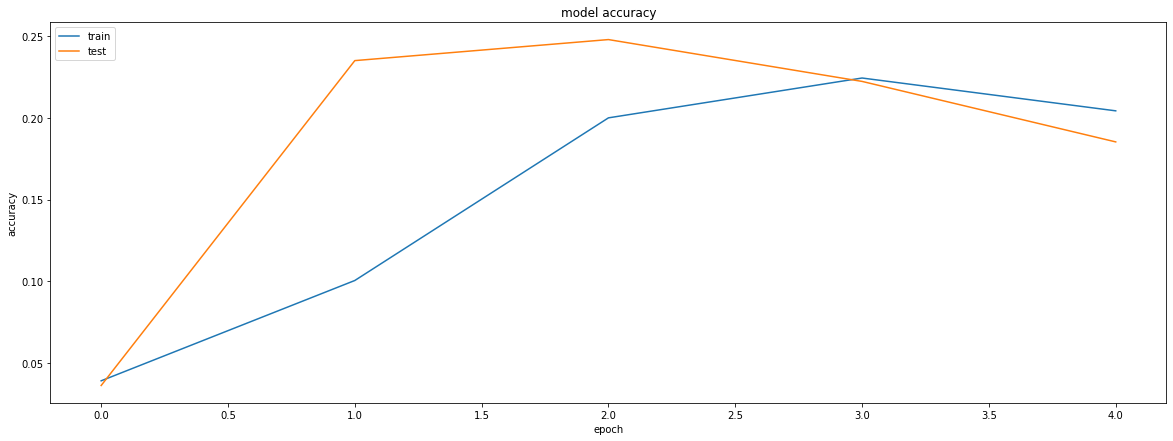

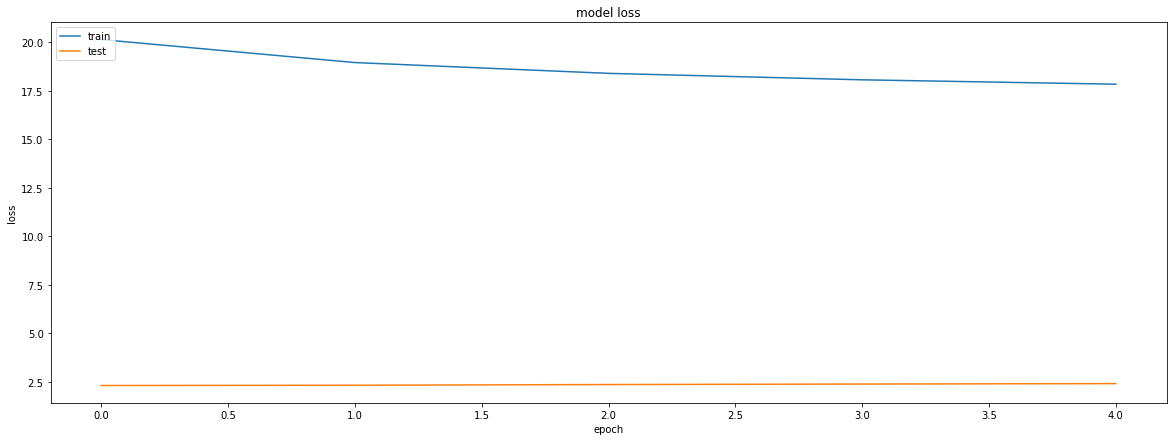

In [19]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

predict the validation classification and score

In [20]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

2022-04-09 19:22:58.603874: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 283681720 exceeds 10% of free system memory.


35/35 [==============================] - 1s 17ms/step


In [21]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.052     0.034     0.042       261
          no      0.056     0.159     0.083       270
          up      0.000     0.000     0.000       260
        down      0.000     0.000     0.000       264
        left      0.044     0.186     0.071       247
       right      0.030     0.055     0.039       256
          on      0.073     0.016     0.026       257
         off      0.056     0.145     0.081       256
        stop      0.040     0.106     0.058       246
          go      0.066     0.265     0.106       260
     silence      0.085     1.000     0.156        41
     unknown      0.658     0.232     0.343      4221

    accuracy                          0.185      6839
   macro avg      0.097     0.183     0.084      6839
weighted avg      0.422     0.185     0.231      6839



In [22]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[  9  20   0   0  56   7   3  44  33  32   7  50]
 [  4  43   0   0  38  18   1  16  22  61  13  54]
 [ 12  33   0   0  46  11   1  15  28  77   7  30]
 [  1  36   1   0  30  32   0  16  23  40  21  64]
 [  7  21   0   0  46   4   1  44  24  31  14  55]
 [  6  29   0   0  33  14   2  23  32  47  15  55]
 [  4  42   2   0  22  26   4  12  26  41  21  57]
 [  8  16   0   0  58  15   3  37  28  39   5  47]
 [  9  38   0   0  24  18   3  22  26  40  23  43]
 [  4  26   1   0  55  16   0  12  13  69  11  53]
 [  0   0   0   0   0   0   0   0   0   0  41   0]
 [108 459  16   1 634 304  37 419 391 569 305 978]]


## Now the CTC model

In [12]:
from models import CTC, ctc_lambda_func #used in the CTC build method
from ctc_utils import char_map, index_map, text_to_int, get_intseq, get_ctc_params

In [13]:
# dummy loss
def ctc(y_true, y_pred):
    return y_pred
   #  return tf.abs(y_pred - y_true)

The Conv1D layer at the top of the CTC model takes a 3-dimensional input, not 4 as the ResNet

In [14]:
sr_ctc = CTC((122,85), 28)
sr_ctc.build()

2022-04-10 10:08:00.776665: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-10 10:08:00.832198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 10:08:00.832355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-10 10:08:00.832374: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-10 10:08:00.855621: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-10 10:08:00.855703: I tensorflow/stream_executor/platf

(<tensorflow.python.keras.engine.functional.Functional at 0x7fbf40dd55d0>,
 <tensorflow.python.keras.engine.functional.Functional at 0x7fbd845c7510>)

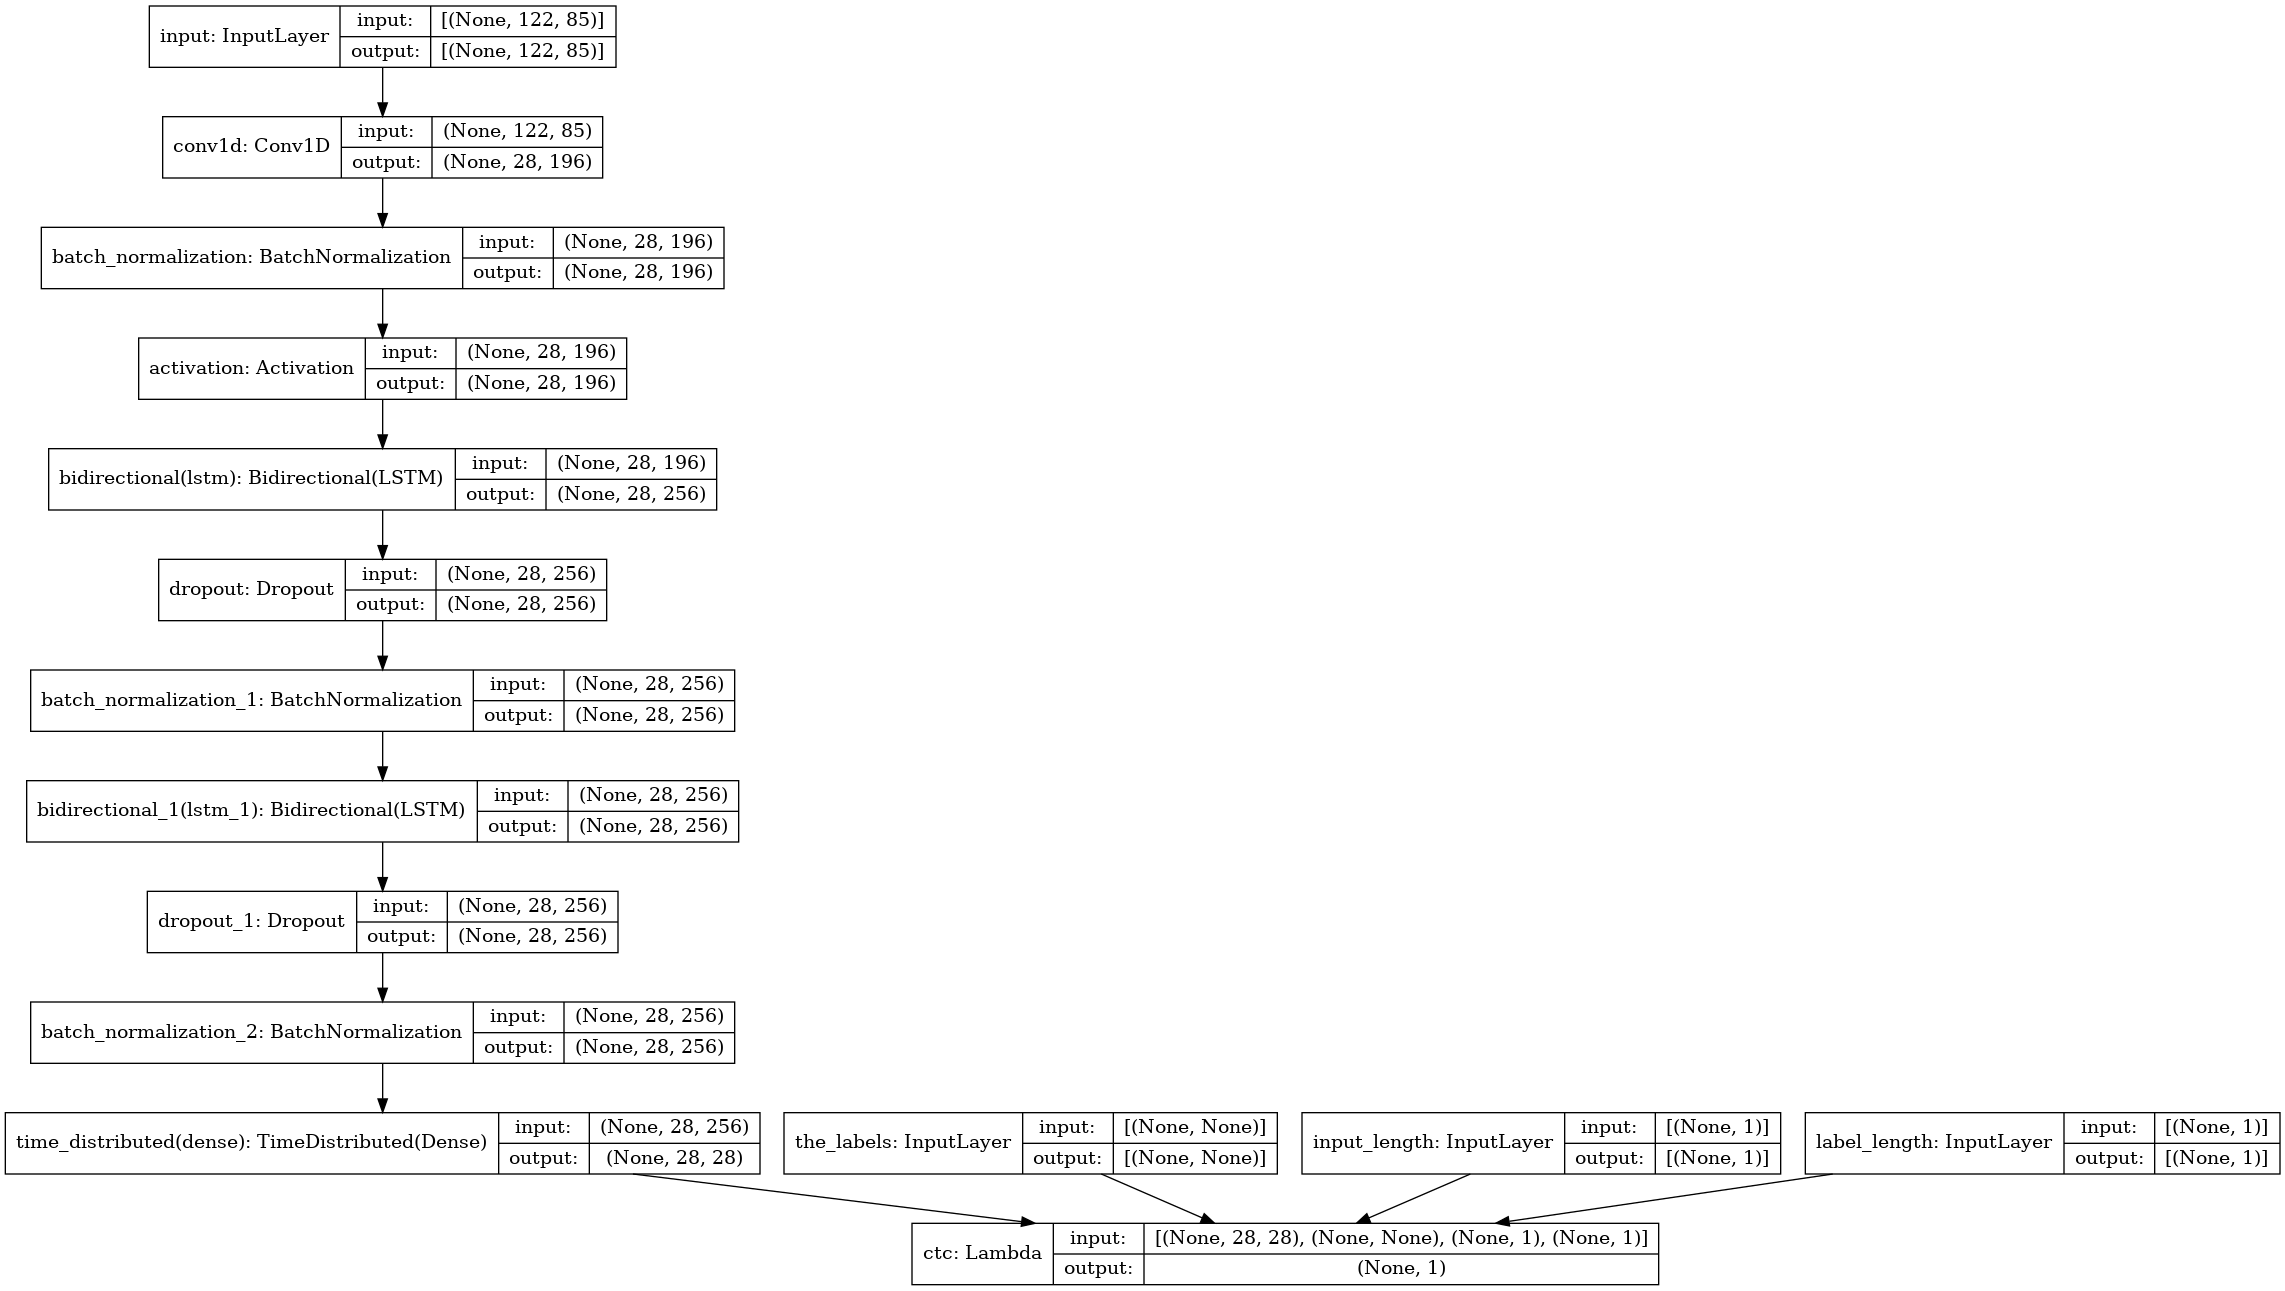

In [15]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr_ctc.m, 
           to_file = './models/ctc_{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [17]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')
# sr_ctc.m.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])
# sr_ctc.tm.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta')

In [18]:
Y_train_all = np.load('data/Y_train_all.npy')
Y_val_all = np.load('data/Y_val_all.npy')

get the ctc parameters needed for the three extra ctc model inputs

In [19]:
labels, input_length, label_length = get_ctc_params(Y = Y_train_all, classes_list = all_classes)
labels_val, input_length_val, label_length_val = get_ctc_params(Y = Y_val_all, classes_list = all_classes)
# labels, input_length, label_length = get_ctc_params(Y = Y_train, classes_list = classes)
# labels_val, input_length_val, label_length_val = get_ctc_params(Y = Y_val, classes_list = classes)

In [20]:
checkpointer = ModelCheckpoint(filepath="./models/ctc_{}_best.h5".format(date),
                               verbose=0,
                               save_best_only=True)

In [21]:
history = sr_ctc.m.fit([np.squeeze(X_train), 
                            labels, 
                            input_length, 
                            label_length], 
                       np.zeros([len(Y_train_all)]), 
                       batch_size = batch_size, 
                       epochs = 10, 
                       validation_data = ([np.squeeze(X_val), 
                                           labels_val, 
                                           input_length_val, 
                                           label_length_val],
                                          np.zeros([len(Y_val_all)])), 
                       callbacks = [checkpointer], 
                       verbose = 1, shuffle = True)


2022-04-09 22:39:50.233728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2417620320 exceeds 10% of free system memory.
2022-04-09 22:39:51.448725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-09 22:39:51.472429: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/10


2022-04-09 22:39:55.352860: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-09 22:39:56.201390: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-04-09 22:39:57.228392: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-09 22:39:57.911402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


297/298 [============================>.] - ETA: 0s - loss: 15.8293 - accuracy: 4.8100e-04

2022-04-09 22:40:18.524863: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 283681720 exceeds 10% of free system memory.


298/298 [==============================] - 30s 78ms/step - loss: 15.8198 - accuracy: 4.8041e-04 - val_loss: 11.1618 - val_accuracy: 0.0060
Epoch 2/10
298/298 [==============================] - 22s 73ms/step - loss: 6.0764 - accuracy: 0.0055 - val_loss: 11.1896 - val_accuracy: 0.0073
Epoch 3/10
298/298 [==============================] - 22s 75ms/step - loss: 3.7825 - accuracy: 0.0572 - val_loss: 13.6158 - val_accuracy: 0.0110
Epoch 4/10
298/298 [==============================] - 25s 83ms/step - loss: 2.7873 - accuracy: 0.1875 - val_loss: 15.1735 - val_accuracy: 0.0110
Epoch 5/10
298/298 [==============================] - 25s 85ms/step - loss: 2.2034 - accuracy: 0.3441 - val_loss: 10.8410 - val_accuracy: 0.0107
Epoch 6/10
298/298 [==============================] - 24s 80ms/step - loss: 1.8105 - accuracy: 0.4715 - val_loss: 8.2275 - val_accuracy: 0.0123
Epoch 7/10
298/298 [==============================] - 25s 83ms/step - loss: 1.5639 - accuracy: 0.5637 - val_loss: 8.8364 - val_accuracy: 

In [31]:
sr_ctc.m.save_weights('./models/ctc_{}.h5'.format(date))
sr_ctc.tm.load_weights('./models/ctc_{}_best.h5'.format(date))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


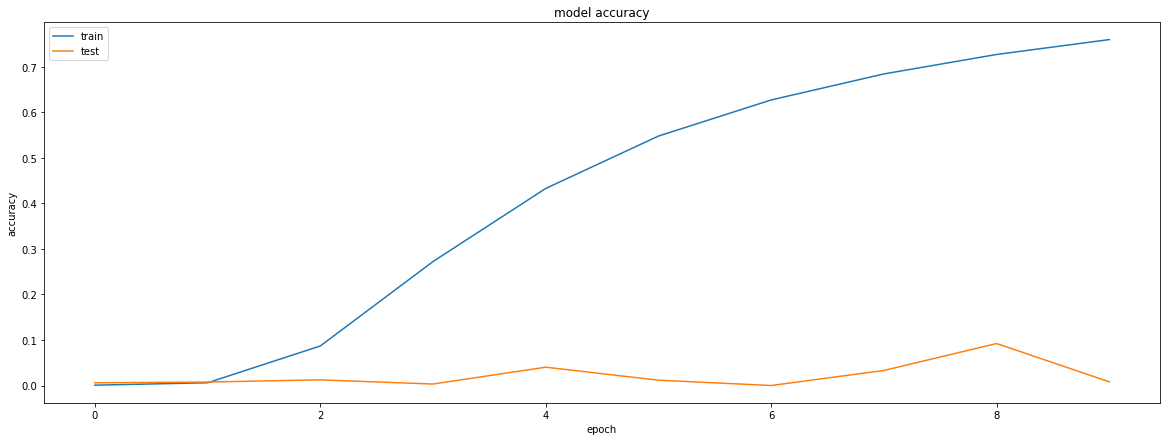

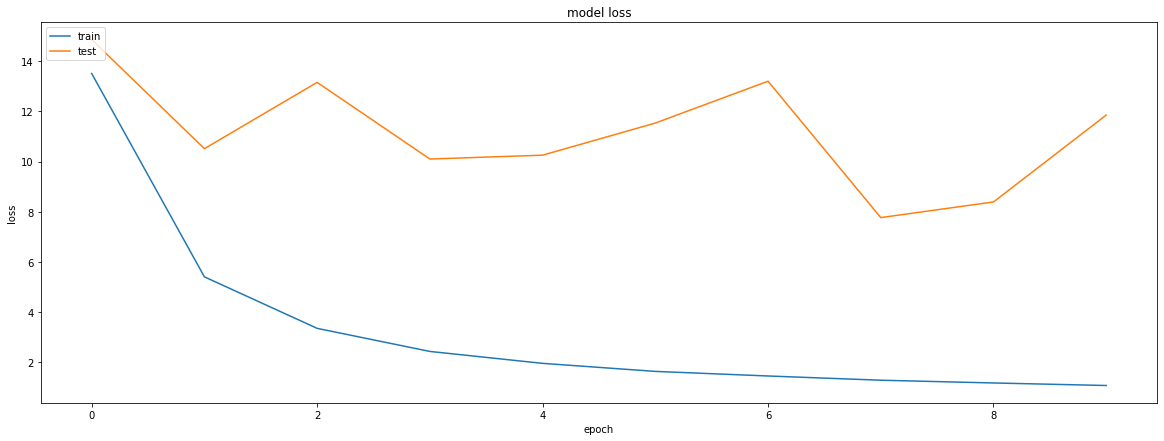

In [113]:
# plot
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_acc.png'.format(date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_loss.png'.format(date), bbox_inches='tight')
plt.show()

decode the output of the predictions into strings

In [74]:
print(X_val.shape)

(6839, 122, 85, 1)


In [63]:
def str_out(dataset = X_val):
    k_ctc_out = K.ctc_decode(sr_ctc.tm.predict(np.squeeze(dataset), 
                                                verbose = 1), 
                             np.array([28 for _ in dataset]))
    decoded_out = K.eval(k_ctc_out[0][0])
    str_decoded_out = []
    for i, _ in enumerate(decoded_out):
        to_join = [index_map[c] for c in decoded_out[i] if not c == -1]
        str_decoded_out.append("".join(to_join))
        
    return str_decoded_out

In [64]:
y_pred_val = str_out()

214/214 [==============================] - 1s 4ms/step


Turn the target array Y_val_all into strings with 'all_classes[Y_val_all[i]]'

In [65]:
print('PREDICTED: \t REAL:')
for i in range(10):
    print(y_pred_val[i], '\t\t',all_classes[Y_val_all[i]])

PREDICTED: 	 REAL:
iseve 		 seven
uppy 		 up
oire 		 one
dow 		 down
bdod 		 down
r 		 on
brd 		 down
 		 zero
go 		 no
five 		 five


In [66]:
print(classification_report([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))

              precision    recall  f1-score   support

         yes       0.99      0.69      0.81       261
          no       0.88      0.19      0.31       270
          up       0.90      0.35      0.50       260
        down       1.00      0.09      0.17       264
        left       0.92      0.47      0.63       247
       right       0.86      0.59      0.70       256
          on       0.73      0.09      0.17       257
         off       0.94      0.24      0.38       256
        stop       1.00      0.08      0.14       246
          go       0.47      0.27      0.34       260
     silence       0.00      0.00      0.00        41
        bird       0.62      0.39      0.48       162
         bed       0.36      0.60      0.45       197
       house       1.00      0.54      0.70       173
       seven       0.98      0.25      0.40       263
         six       0.99      0.51      0.68       262
        nine       1.00      0.18      0.30       230
         dog       0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


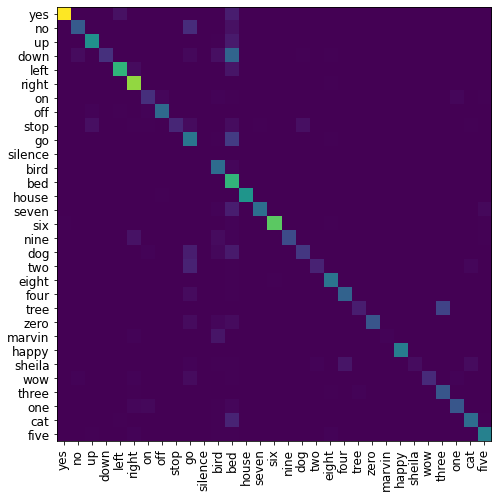

In [67]:
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))
plt.xticks(np.arange(0, len(all_classes)), all_classes, rotation = 'vertical', size = 12)
plt.yticks(np.arange(0, len(all_classes)), all_classes, size = 12)
plt.show()